In [51]:
import plotly; import pandas as pd; import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats import spearmanr
from collections import Counter
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Make figures look good for hi-res displays.

# Comparing Retweet Streams

In [52]:
#Dataset: 
df = pd.read_json('/data/diffusion/cdc_userstreams_top_25_retweeted_2020-06-09.json')

#View the raw data
df.head(2)

,id,created_at,username,followers_count,source,followers_count_cumsum,text,top_N
0,1253786298390732800,2020-04-24 20:42:02+00:00,mylow196,13,"<a href=""http://twitter.com/download/iphone"" r...",9922339,Household cleaners and disinfectants can cause...,1
1,1254038937825402880,2020-04-25 13:25:56+00:00,stewonthis1,11238,"<a href=""http://twitter.com/download/iphone"" r...",15751053,Household cleaners and disinfectants can cause...,1


In [53]:
def get_retweets_after_trump(df, window=1, debug=False):
    """
        Returns a dictionary keyed by topN with dataframes as values of all the retweets of that tweet.
    """
    retweets_after_trump = {}

    for t, retweets in df.groupby('top_N'):
        retweets.sort_values(by='created_at').reindex()
        index_of_trump_retweet = retweets[retweets.username == 'realDonaldTrump'].index
        
        if t == 1: #The tweet he deleted
            if debug: 
                print("Tweet TopN #: {}; ".format(t), end="")
            trumpTime = pd.Timestamp("20200425T13:01:55Z")
            max_time  = trumpTime + pd.Timedelta(hours=window)
            
            if debug: 
                print('we think @realDonaldTrump retweeted at '+ str(trumpTime))

            in_window = retweets[(retweets.created_at > trumpTime ) & (retweets.created_at <= max_time)]
            if debug: 
                print(str(len(in_window)) + " retweets in {} hour(s) after Trump".format(window)+"\n")
            
            retweets_after_trump[t] = pd.DataFrame.copy(in_window)
            retweets_after_trump[t]['timeSinceTrump'] = (retweets_after_trump[t].created_at - trumpTime)
        
        elif index_of_trump_retweet.any() > 0:
            if debug: 
                print("Tweet TopN #: {}; ".format(t), end="")
            tweet = retweets.loc[min(index_of_trump_retweet)]
            if debug: 
                print('@realDonaldTrump retweeted at '+ str( tweet.created_at))

            max_time = tweet.created_at + pd.Timedelta(hours=window)

            in_window = retweets[(retweets.created_at > tweet.created_at ) & (retweets.created_at <= max_time)]
            if debug: 
                print(str(len(in_window)) + " retweets in {} hour(s) after Trump".format(window)+"\n")
            
            retweets_after_trump[t] = pd.DataFrame.copy(in_window)
            retweets_after_trump[t]['timeSinceTrump'] = (retweets_after_trump[t].created_at - tweet.created_at)
            
    # How many tweets do users retweet?
    all_users = []
    all_sources = []
    for k in retweets_after_trump.keys():
        all_users   += list(retweets_after_trump[k].username)
        all_sources += list(retweets_after_trump[k].source)
    source_counts = Counter(all_sources)
    user_counts   = Counter(all_users)
            
    return [retweets_after_trump, source_counts, user_counts]

def calculate_similarity_of_tweeters_in_two_streams(streamA, streamB):
    """
        Returns the percentage of users that present in both streams
    """
    return len( set(streamA.username) & set(streamB.username) ) / min(len(streamA),len(streamB) )* 100

def rank_twitterers(streamA, streamB):
    """
    Returns dataframe for plotting
    """
    
    users = set(streamA.username) & set(streamB.username)
    
    p_similar = calculate_similarity_of_tweeters_in_two_streams(streamA,streamB);
    
#     print("The % similar is: {:.2f} with {} users in both streams".format(p_similar, len(users)))


    to_return = []
#         #Now remove users from each stream that aren't present in both.
#         A = list( streamA[ streamA.username.apply(lambda u: u in users) ].username )
#         B = list( streamB[ streamB.username.apply(lambda u: u in users) ].username )

#         for u in list(users):
#             to_return.append(
#             {'user':u, 'rankInA':A.index(u), 'rankInB' : B.index(u)})

    for u in list(users):
        to_return.append(
            {'user':u, 
             'rankInA':streamA[streamA.username==u].timeSinceTrump.values[0],
             'rankInB':streamB[streamB.username==u].timeSinceTrump.values[0],
             'sourceA':streamA[streamA.username==u].source.values[0],
             'sourceB':streamB[streamB.username==u].source.values[0]})

    thisDF = pd.DataFrame(to_return)
    sr = spearmanr(thisDF.rankInA, thisDF.rankInB)
#     print(sr)

    return thisDF, sr, p_similar

In [82]:
COLORS = plotly.colors.cyclical.Edge
def hoverTemplate(row):
    return row.user + ": " + row.sourceA

def make_plot(df2, user_counts):
    
    df2['counts'] = df2.user.apply(lambda x: user_counts[x])
    
#     print(df2.counts.max())
    
    fig = go.Figure()

    for count, rts in df2.groupby('counts'):
        if count < 17:
            fig.add_trace(go.Scattergl(
                name = 'Retweeted {} tweets'.format(count),
                x    = rts.rankInA.apply(lambda x: x.total_seconds()),
                y    = rts.rankInB.apply(lambda x: x.total_seconds()), 
                mode = 'markers',
                marker = dict(
                    size  = 8,
                    color = COLORS[count-1],
                    opacity = 1
                ),
                hovertemplate ='%{text}',
                text = rts.apply(lambda row: hoverTemplate(row), axis=1),
                showlegend = True
            ))

    fig.update_layout(
        autosize=False,
        width=800,
        height=600,
        margin=dict(
            t=50,r=50,l=1,b=1
        ),
        legend=dict(
            x=1,
            y=1,
            traceorder="normal",
            font=dict(
                family="sans-serif",
                size=12,
                color="black"
            )),
        title="Tweet #{} vs Tweet #{}".format(A,B),
        xaxis_title="Seconds since Trump Retweeted #{}".format(A),
        yaxis_title="Seconds since Trump Retweeted #{}".format(B))
    return fig

# For `X` hour windows:

In [83]:
window=48

retweets_after_trump, source_counts, user_counts = get_retweets_after_trump(df, window=window)

#Which should we compare?
A = 1
B = 2

df2, sr, p = rank_twitterers(retweets_after_trump[A], retweets_after_trump[B])
print("The % similar is: {:.2f} with {} users in both streams".format(p, len(df2)))
print(sr)


f = make_plot(df2, user_counts)
f.show()

with open('/data/www/tmp.html','w') as outFile:
    outFile.write( plotly.io.to_html(f,include_plotlyjs='cdn') )

The % similar is: 61.63 with 1682 users in both streams
SpearmanrResult(correlation=0.973262414256706, pvalue=0.0)


# Do all of them...

In [86]:
window=24

retweets_after_trump, source_counts, user_counts = get_retweets_after_trump(df, window=window)


for A in retweets_after_trump.keys():
    for B in retweets_after_trump.keys():
        if B > A:
            df2, sr, p = rank_twitterers(retweets_after_trump[A], retweets_after_trump[B])
            
            f = make_plot(df2, user_counts)
            with open('/data/www/covid19-static-pages/docs/retweet_correlations/{}_{}_{}H.html'.format(A,B,window),'w') as outFile:
                outFile.write( plotly.io.to_html(f,include_plotlyjs='cdn') )

            print("{},{},{},{},{},https://epic.cs.colorado.edu/covid19/retweet_correlations/{}_{}_{}H.html".format(A,B,p,sr.correlation,sr.pvalue,A,B,window))


1,2,62.17287866772403,0.9719712888455362,0.0,https://epic.cs.colorado.edu/covid19/retweet_correlations/1_2_24H.html
1,3,53.31196581196581,0.911684838857383,0.0,https://epic.cs.colorado.edu/covid19/retweet_correlations/1_3_24H.html
1,4,35.00712250712251,0.19461052341994148,7.615299851498518e-10,https://epic.cs.colorado.edu/covid19/retweet_correlations/1_4_24H.html
1,5,39.15978994748687,0.23101491081966985,4.098212983847099e-14,https://epic.cs.colorado.edu/covid19/retweet_correlations/1_5_24H.html
1,6,59.27357032457496,0.95924803259054,0.0,https://epic.cs.colorado.edu/covid19/retweet_correlations/1_6_24H.html
1,7,55.83203732503888,0.8066950044989141,0.0,https://epic.cs.colorado.edu/covid19/retweet_correlations/1_7_24H.html
1,8,60.16260162601627,0.9543718210003104,0.0,https://epic.cs.colorado.edu/covid19/retweet_correlations/1_8_24H.html
1,10,57.245762711864415,0.8064800687799032,3.635370914849e-310,https://epic.cs.colorado.edu/covid19/retweet_correlations/1_10_24H.html
1,11,58.7927565392

7,11,55.53319919517102,0.7564282125519796,2.452302059764532e-256,https://epic.cs.colorado.edu/covid19/retweet_correlations/7_11_24H.html
7,12,39.23524522028263,0.22466406998949645,2.889000889129826e-12,https://epic.cs.colorado.edu/covid19/retweet_correlations/7_12_24H.html
7,13,68.1203007518797,0.808703591283305,4.891799473e-315,https://epic.cs.colorado.edu/covid19/retweet_correlations/7_13_24H.html
7,14,69.0049751243781,0.8132535930130816,0.0,https://epic.cs.colorado.edu/covid19/retweet_correlations/7_14_24H.html
7,15,66.10754810064134,0.7837731089323781,4.416009415873886e-279,https://epic.cs.colorado.edu/covid19/retweet_correlations/7_15_24H.html
8,10,57.11864406779661,0.7637493358020778,3.8567350756212066e-258,https://epic.cs.colorado.edu/covid19/retweet_correlations/8_10_24H.html
8,11,73.86178861788618,0.9662010080900741,0.0,https://epic.cs.colorado.edu/covid19/retweet_correlations/8_11_24H.html
8,12,41.64588528678304,0.2098500615689757,1.9566156185460786e-11,https://epic.cs.colora

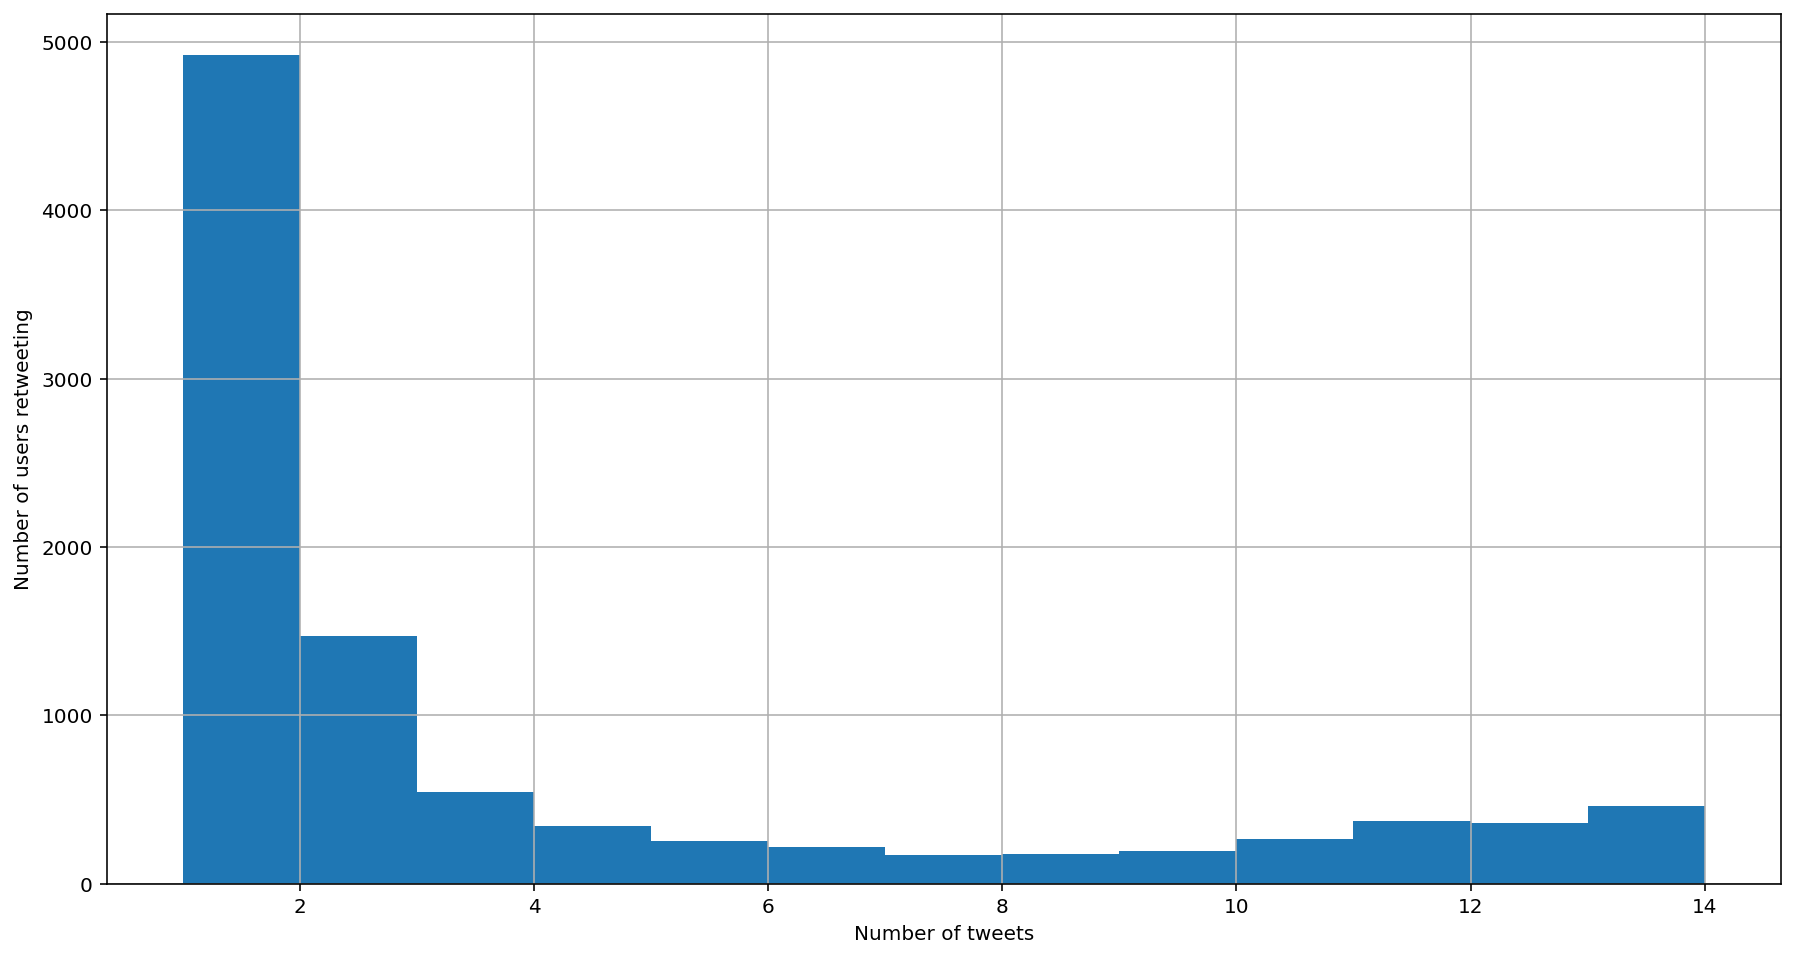

In [87]:
ax = pd.Series([x[1] for x in user_counts.most_common()]).hist(figsize=(15,8), bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14])
ax.set_ylabel("Number of users retweeting")
ax.set_xlabel("Number of tweets");